# Isomap

In [3]:
import setup
from circuits import * 

In [158]:
from sklearn.utils.graph import single_source_shortest_path_length

In [329]:
from sklearn.datasets import load_digits
from sklearn.manifold import Isomap
X, _ = load_digits(return_X_y=True)
X = X[:100]
X.shape

(100, 64)

In [330]:
embedding = Isomap(n_components=49, n_neighbors=9)
X_transformed = embedding.fit_transform(X)
X_transformed.shape

(100, 49)

<Figure size 432x288 with 0 Axes>

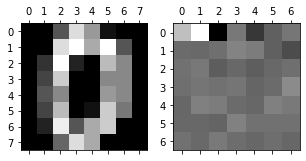

<Figure size 432x288 with 0 Axes>

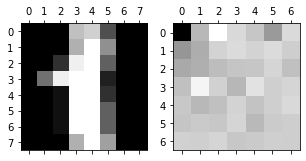

<Figure size 432x288 with 0 Axes>

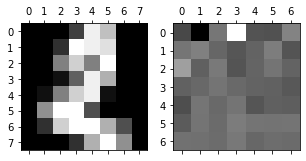

In [331]:
# Fading out for large components indicates less informative

for i in range(3):
    plt.gray()
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 5))

    axes[0].matshow(np.array(X[i]).reshape(8,8))
    axes[1].matshow(X_transformed[i].real.reshape(7,7))

    plt.show()

## My Isomap

In [366]:
def kNN(x,X, k=5):
    dists = X.apply(lambda y: np.linalg.norm(x-y), axis=1)
    dists = dists.sort_values()
    dists[set(dists.index) - set(dists.head(k+1).index)] = 0 
    return dists.sort_index()
    
    

In [350]:
X = pd.DataFrame(X)

In [368]:
kNN(X.iloc[0],X,k=9).sort_values(ascending=False)

78    30.512293
55    30.430248
49    27.184554
20    26.095977
48    24.186773
        ...    
32     0.000000
31     0.000000
29     0.000000
28     0.000000
99     0.000000
Length: 100, dtype: float64

In [369]:
cols = []
for i,x in X.iterrows():
    cols.append(np.array(kNN(x,X,k=9)))

In [370]:
dij_N = np.column_stack(cols)


In [371]:
dij_N.T[0]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       23.70653918,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       26.0959767 ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       20.78460969,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , 21.74856317,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , 24.18677324, 27.18455444,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       30.43024811,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [372]:
dij_N = dij_N.T

In [373]:
dists_geodesic = []
for i in range(dij_N.shape[0]):
    dists_geodesic.append(np.array(pd.Series(single_source_shortest_path_length(dij_N, i)).sort_index()))

In [374]:
dij_geo = np.column_stack(dists_geodesic)


In [375]:
dij_geo

array([[ 0,  5,  4, ...,  3,  6,  4],
       [ 8,  0,  3, ...,  3, 10,  1],
       [ 8,  4,  0, ...,  5,  9,  3],
       ...,
       [ 7,  3,  4, ...,  0,  9,  2],
       [ 4,  5,  3, ...,  4,  0,  4],
       [ 8,  1,  2, ...,  3,  9,  0]], dtype=int64)

In [265]:
from sklearn.decomposition import KernelPCA

In [266]:
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import pairwise_kernels

from sklearn.preprocessing import KernelCenterer

In [267]:
K = dij_geo**2

In [268]:

K_transformer = KernelCenterer().fit(K)
K_transformer
K = K_transformer.transform(K)

In [269]:
evals, evecs = np.linalg.eig(K)

In [270]:
d= len(X.columns)

In [271]:
from sklearn.utils.extmath import svd_flip

# Flips evecs sign if its largest element by absolute value is negative (for uniqueness?) 
evecs, _ = svd_flip(
   evecs, np.zeros_like(evecs).T
)

In [272]:
Z = []
for n in range(len(evecs)):
    zn = np.asarray([np.sqrt(evals[i])*evecs[n][i] for i in range(d)])
    Z.append(zn)
Z = np.asarray(Z)

<Figure size 432x288 with 0 Axes>

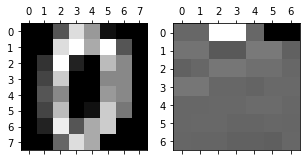

<Figure size 432x288 with 0 Axes>

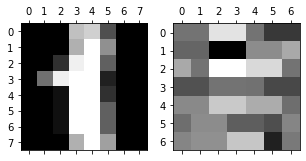

<Figure size 432x288 with 0 Axes>

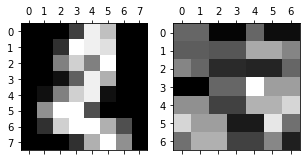

In [274]:
# Fading out for large components indicates less informative

for i in range(3):
    plt.gray()
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 5))

    axes[0].matshow(np.array(X.iloc[i]).reshape(8,8))
    axes[1].matshow(Z[i][:49].real.reshape(7,7))

    plt.show()

In [278]:

Kernel = KernelPCA(
    n_components=49,
    kernel="precomputed"
)

In [286]:
dij_geo

array([[ 0,  8,  8, ...,  7,  4,  8],
       [ 5,  0,  4, ...,  3,  5,  1],
       [ 4,  3,  0, ...,  4,  3,  2],
       ...,
       [ 3,  3,  5, ...,  0,  4,  3],
       [ 6, 10,  9, ...,  9,  0,  9],
       [ 4,  1,  3, ...,  2,  4,  0]], dtype=int64)

## Source

In [315]:
from sklearn.neighbors import NearestNeighbors, kneighbors_graph
from scipy.sparse.csgraph import connected_components, shortest_path

In [316]:
Kernel = KernelPCA(
    n_components=49,
    kernel="precomputed"
)

In [317]:
k = 9

In [318]:
nbrs = NearestNeighbors(
            n_neighbors=9,
            radius=None,
            algorithm='auto',
            metric='minkowski',
            p=2,
            metric_params=None,
            n_jobs=None,
        )

In [319]:
nbrs.fit(X)

NearestNeighbors(n_neighbors=9, radius=None)

In [320]:
nbg = kneighbors_graph(
                nbrs,
                k,
                metric='minkowski',
                p=2,
                metric_params=None,
                mode='distance',
                n_jobs=None,
            )

In [321]:
n_connected_components, labels = connected_components(nbg)

In [322]:
n_connected_components

1

In [494]:
G = shortest_path(dij_N.T, method="auto", directed=False)

In [495]:
G = G**2

In [489]:
#G *= -0.5

In [496]:
K_transformer = KernelCenterer().fit(G)
K_transformer
K = K_transformer.transform(G)

In [497]:
X_transformed = Kernel.fit_transform(G)

ValueError: There are significant negative eigenvalues (0.00181339 of the maximum positive). Either the matrix is not PSD, or there was an issue while computing the eigendecomposition of the matrix.

<Figure size 432x288 with 0 Axes>

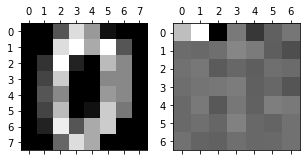

<Figure size 432x288 with 0 Axes>

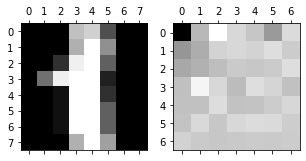

<Figure size 432x288 with 0 Axes>

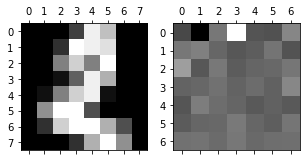

In [498]:
# Fading out for large components indicates less information

for i in range(3):
    plt.gray()
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 5))

    axes[0].matshow(np.array(X.iloc[i]).reshape(8,8))
    axes[1].matshow(X_transformed[i].reshape(7,7))

    plt.show()